In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from statannot import add_stat_annotation
from adjustText import adjust_text

anot = pd.read_csv('aneuploidy_data_NEW.csv',index_col=0)

anot_CCLE = anot.copy()
anot_CCLE.index = anot_CCLE.loc[:,'CCLE_ID']

# from cds import plotting

my_pal = {"Diploid": "C0", "Aneuploid": "firebrick"}
my_order = order=['Diploid','Aneuploid']

from taigapy import TaigaClient
tc = TaigaClient()

gene_effect_rnai_achilles = tc.get(name='demeter2-achilles-5386', version=13, file='gene_effect')
gene_effect_rnai_drive = tc.get(name='demeter2-drive-0591', version=12, file='gene_effect')
gene_effect_crispr_achilles = tc.get(name='avana-public-tentative-19q4-c2df', version=4, file='gene_effect')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

central
nervous
system_Aneuploid v.s. central
nervous
system_Diploid: t-test independent samples, P_val=2.911e-01 stat=-1.122e+00
colorectal_Aneuploid v.s. colorectal_Diploid: t-test independent samples, P_val=9.691e-01 stat=3.916e-02
uterus_Aneuploid v.s. uterus_Diploid: t-test independent samples, P_val=3.679e-03 stat=-3.767e+00
ovary_Aneuploid v.s. ovary_Diploid: t-test independent samples, P_val=2.027e-02 stat=-3.353e+00
gastric_Aneuploid v.s. gastric_Diploid: t-test independent samples, P_val=4.505e-01 stat=-8.181e-01
skin_Aneuploid v.s. skin_Diploid: t-test independent samples, P_val=5.444e-01 stat=-6.254e-01


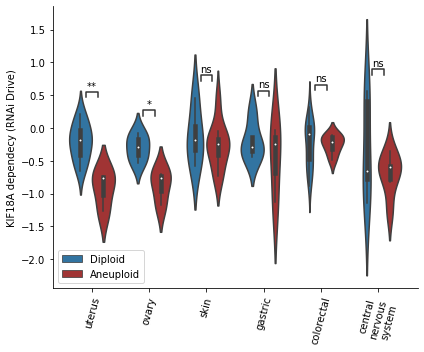

In [3]:
##########################################################################################
######################################### figex 10a ######################################
##########################################################################################

sample_info = tc.get(name='internal-19q4-fb11', version=29, file='sample_info')

sample_info.index = sample_info.loc[:,'CCLE_Name'] 

sample_info = sample_info[~sample_info.index.duplicated(keep='first')]

lin_order = ['skin','lung','uterus','gastric','colorectal','ovary','bone']
shared = set(anot_CCLE.index) & set(gene_effect_rnai_drive.index) 
#without_na = gene_effect_rnai_drive.loc[shared,'MAD2L1 (4085)'].dropna().index & shared


drive_box = gene_effect_rnai_drive.loc[shared]

drive_box['lineage'] = sample_info.loc[drive_box.index,'lineage']





drive_box['ploidy'] = anot_CCLE.loc[drive_box.index,'many_arm_events']

trus = drive_box[drive_box.loc[:,'ploidy']==True].index 
drive_box.loc[trus,'ploidy']= 'Aneuploid'
falsee = drive_box[drive_box.loc[:,'ploidy']==False].index 
drive_box.loc[falsee,'ploidy']=  'Diploid'

#only lineages we want

to_drop = []

for x in drive_box.index:
    if  drive_box.loc[x,'lineage'] != 'uterus' \
        and drive_box.loc[x,'lineage'] != 'ovary' and drive_box.loc[x,'lineage'] != 'skin' \
        and drive_box.loc[x,'lineage'] != 'gastric' and drive_box.loc[x,'lineage'] != 'colorectal' \
        and drive_box.loc[x,'lineage'] != 'central_nervous_system' :
            to_drop.append(x)
            
drive_box_ = drive_box.drop(to_drop)
drive_box_ = drive_box_.replace('central_nervous_system','central\nnervous\nsystem')

lin_order = ['uterus','ovary','skin','gastric','colorectal','central\nnervous\nsystem']
##########################################################################################################
l_order = list(set(drive_box_.loc[:,'lineage']))

plt.subplots(figsize=(6,5))

ax = sns.violinplot(x="lineage", y="KIF18A (81930)", hue="ploidy",
                     data=drive_box_ ,palette = my_pal,order = lin_order,hue_order=['Diploid','Aneuploid'])#palette="muted")

new_pairs = []

for lin in set(drive_box_['lineage'].values):
    #print(lin)
    new_pairs.append(((lin,'Diploid'),(lin,'Aneuploid')))

# box_pairs=[
#     (("skin", "Diploid"), ("skin", "Aneuploid")),
#     (("uterus", "Diploid"), ("uterus", "Aneuploid")),
#     (("gastric", "Diploid"), ("gastric", "Aneuploid")),
#     (("colorectal", "Diploid"), ("colorectal", "Aneuploid")),
#     (("ovary", "Diploid"), ("ovary", "Aneuploid")),
#     (("lung", "Diploid"), ("lung", "Aneuploid")),
#     (("bone", "Diploid"), ("bone", "Aneuploid")),
    
#     ]
width = 0.4
add_stat_annotation(ax, data=drive_box_, x='lineage', y='KIF18A (81930)', hue='ploidy', width=width,
                    box_pairs=new_pairs, test='t-test_ind', loc='inside', verbose=2,order=lin_order,comparisons_correction=None)




plt.xticks(rotation=75) 
plt.ylabel('KIF18A dependecy (RNAi Drive)')
plt.xlabel('')


# plotting.simpleaxis(ax)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:],loc='lower left')
plt.tight_layout()

No handles with labels found to put in legend.


RNAi Achilles p-value for KIF18A: 0.024347529094318934


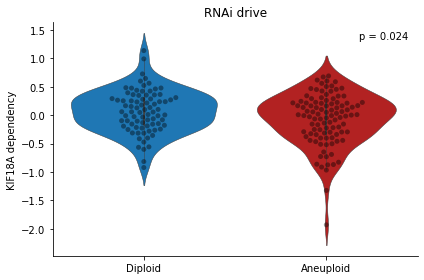

In [8]:
##########################################################################################
######################################### figex 10b ######################################
##########################################################################################
# correct for lineage
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')


genes = ['KIF18A (81930)']

gene_effect_rnai_drive_ = gene_effect_rnai_drive.loc[:,genes].dropna()

one_hot = pd.get_dummies(sample_info.loc[set(gene_effect_rnai_drive_.index & sample_info.index),'lineage'])
mu = gene_effect_rnai_drive_.mean()
reg = LinearRegression().fit(one_hot, gene_effect_rnai_drive_.loc[set(gene_effect_rnai_drive_.index & sample_info.index)])
preds = pd.DataFrame(reg.predict(one_hot),index = gene_effect_rnai_drive_.loc[set(gene_effect_rnai_drive_.index & sample_info.index)].index,columns = gene_effect_rnai_drive_.columns)

preds_ = preds 
corrected_rnai_drive = ((gene_effect_rnai_drive_ - mu) - preds_)+ mu

fig,axx = plt.subplots()


shared = set(anot.loc[:,'CCLE_ID']) & set(corrected_rnai_drive.index)
temp = corrected_rnai_drive.loc[shared]
temp['ploidy'] = anot_CCLE.loc[temp.index,'many_arm_events']

trus = temp[temp.loc[:,'ploidy']==True].index 
temp.loc[trus,'ploidy']= 'Aneuploid'
falsee = temp[temp.loc[:,'ploidy']==False].index 
temp.loc[falsee,'ploidy']=  'Diploid'




sns.violinplot(y = 'KIF18A (81930)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx,order=['Diploid','Aneuploid'],palette=my_pal)
sns.swarmplot(y = 'KIF18A (81930)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx,order=['Diploid','Aneuploid'])
axx.set_title('RNAi drive')
axx.set_ylabel('KIF18A dependency')
axx.set_xlabel('')

# plotting.simpleaxis(axx[1])
plt.tight_layout()

axx.spines['right'].set_visible(False)
axx.spines['top'].set_visible(False)




tt,p_val = stats.ttest_ind(corrected_rnai_drive.loc[trus,'KIF18A (81930)'],corrected_rnai_drive.loc[falsee,'KIF18A (81930)'])
print('RNAi Achilles p-value for KIF18A: ' + str(p_val))
axx.legend(title='p = '+ str(round(p_val,3)),frameon=False)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT_Aneuploid v.s. WT_Diploid: t-test independent samples, P_val=3.354e-01 stat=-9.721e-01


/usr/local/lib/python3.8/site-packages/statannot/statannot.py:337: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = box_plotter.plot_hues[index] == hue_level


damaging_Aneuploid v.s. damaging_Diploid: t-test independent samples, P_val=1.119e-01 stat=-1.620e+00
hotspot_Aneuploid v.s. hotspot_Diploid: t-test independent samples, P_val=8.663e-03 stat=-2.697e+00


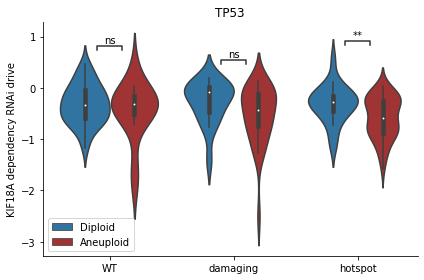

In [13]:
##########################################################################################
######################################### figex 10c ######################################
##########################################################################################

gene_effect_rnai_achilles_ = gene_effect_rnai_achilles.copy()
gene_effect_rnai_drive_ = gene_effect_rnai_drive.loc[set(gene_effect_rnai_drive.index & sample_info.index)].copy()

gene_effect_rnai_achilles_.index = sample_info.loc[gene_effect_rnai_achilles.index,'DepMap_ID']
gene_effect_rnai_drive_.index = sample_info.loc[set(gene_effect_rnai_drive.index & sample_info.index),'DepMap_ID']

damaging_mutation = tc.get(name='depmap-mutation-calls-9a1a', version=14, file='damaging_mutation')
depmap_19Q4_mutation_calls = tc.get(name='depmap-mutation-calls-9a1a', version=14, file='depmap_19Q4_mutation_calls')
hotspot_mutation = tc.get(name='depmap-mutation-calls-9a1a', version=14, file='hotspot_mutation')
other_mutation = tc.get(name='depmap-mutation-calls-9a1a', version=14, file='other_mutation')


damaging_mutation.columns = damaging_mutation.columns.str.split(' ').str[0]
hotspot_mutation.columns = hotspot_mutation.columns.str.split(' ').str[0]
other_mutation.columns = other_mutation.columns.str.split(' ').str[0]

all_lines = set(damaging_mutation.index) | set(hotspot_mutation.index) | set(other_mutation.index)
all_columns = set(damaging_mutation.columns) | set(hotspot_mutation.columns) | set(other_mutation.columns)

dam_tp53 = pd.Series('damaging',index=damaging_mutation.loc[:,'TP53'][damaging_mutation.loc[:,'TP53']==1].index)

hot_tp53 = pd.Series('hotspot',index=hotspot_mutation.loc[:,'TP53'][hotspot_mutation.loc[:,'TP53']==1].index)

other_tp53 = pd.Series('other',index=other_mutation.loc[:,'TP53'][other_mutation.loc[:,'TP53']==1].index)



other_tp53 = other_tp53.loc[set(other_tp53.index) - set(dam_tp53.index) - set(hot_tp53.index)]
hot_tp53 = hot_tp53.loc[set(hot_tp53.index) - set(dam_tp53.index)]


tp53_mutations = pd.concat([pd.concat([dam_tp53,hot_tp53]),other_tp53])

wt_tp53 = pd.Series('WT',index = set(all_lines) - set(tp53_mutations.index))

all_tp53 = pd.concat([tp53_mutations,wt_tp53])

all_tp53 = pd.concat([tp53_mutations,wt_tp53])
all_tp53 = pd.DataFrame(all_tp53,columns=['status'])
# all_tp53['BUB1B'] = gene_effect_rnai_drive_.loc[all_tp53.index,'BUB1B (701)']
# all_tp53['MAD2L1'] = gene_effect_rnai_drive_.loc[all_tp53.index,'MAD2L1 (4085)']
all_tp53['KIF18A'] = gene_effect_rnai_drive_.loc[set(all_tp53.index &gene_effect_rnai_drive_.index),'KIF18A (81930)']




shared = set(anot.index) & set(all_tp53.dropna().index)
temp = all_tp53.dropna().copy()
temp['ploidy'] = anot.loc[set(temp.index & anot.index),'many_arm_events']

trus = temp[temp.loc[:,'ploidy']==True].index 
temp.loc[trus,'ploidy']= 'Aneuploid'
falsee = temp[temp.loc[:,'ploidy']==False].index 
temp.loc[falsee,'ploidy']=  'Diploid'


box_pairs=[
    (("WT", "Diploid"), ("WT", "Aneuploid")),
    (("damaging", "Diploid"), ("damaging", "Aneuploid")),
    (("hotspot", "Diploid"), ("hotspot", "Aneuploid")),
    #(("other", "Diploid"), ("other", "Aneuploid"))
    ]

temp=temp.dropna()

ax = sns.violinplot(x="status", y="KIF18A", hue="ploidy",
                     data=temp,palette = my_pal,
                   hue_order=['Diploid','Aneuploid'],order=['WT', 'damaging', 'hotspot', 'other'])#palette="muted")

plt.xlabel('')
plt.ylabel('KIF18A dependency RNAi drive')


width = 0.4
add_stat_annotation(ax, data=temp,x="status", y='KIF18A', hue='ploidy', width=width,
                    box_pairs=box_pairs, test='t-test_ind', loc='inside', verbose=2,order=['WT', 'damaging', 'hotspot', 'other'],comparisons_correction=None)

plt.title('TP53')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:],loc = 'lower left')
plt.tight_layout()
# plotting.simpleaxis()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

No handles with labels found to put in legend.


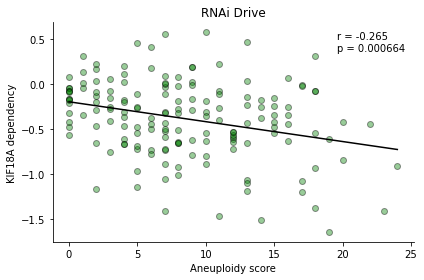

In [14]:
##########################################################################################
######################################### figex 10d ######################################
##########################################################################################

import scipy
CCLE_ABSOLUTE_combined_table = tc.get(name='ccle-absolute-cn', version=5, file='CCLE_ABSOLUTE_combined_table')

CCLE_ABSOLUTE_combined_table.index = CCLE_ABSOLUTE_combined_table.loc[:,'CCLE_ID']

zero_dups = CCLE_ABSOLUTE_combined_table[CCLE_ABSOLUTE_combined_table.loc[:,'Genome doublings'] == 0].index
full_anot =tc.get(name='aneuploidy-data-d0b9', version=18, file='aneuploidy_data_NEW')

full_anot.index = full_anot.loc[:,'DepMap_ID']

full_anot_CCLE = full_anot.copy()
full_anot_CCLE.index = full_anot.loc[:,'CCLE_ID']


fig,ax = plt.subplots()

sh = set(full_anot_CCLE.index & gene_effect_rnai_drive.loc[:,'KIF18A (81930)'].dropna().index & CCLE_ABSOLUTE_combined_table[CCLE_ABSOLUTE_combined_table.loc[:,'Genome doublings'] == 0].index)


ax.set_xlabel('')
ax.set_ylabel('KIF18A dependency')
ax.scatter(full_anot_CCLE.loc[sh,'num_arm_events'],gene_effect_rnai_drive.loc[sh,'KIF18A (81930)'],color='green',alpha=.4,edgecolor='black',label=None)
ax.set_xlabel('Aneuploidy score')
ax.set_title('RNAi Drive')

ax.plot(np.unique(full_anot_CCLE.loc[sh,'num_arm_events']), np.poly1d(np.polyfit(full_anot_CCLE.loc[sh,'num_arm_events'], gene_effect_rnai_drive.loc[sh,'KIF18A (81930)'], 1))(np.unique(full_anot_CCLE.loc[sh,'num_arm_events'])),color='black')
r,p = scipy.stats.spearmanr(full_anot_CCLE.loc[sh,'num_arm_events'],gene_effect_rnai_drive.loc[sh,'KIF18A (81930)'])
ax.legend(title='r = ' + str(round(r,3)) + '\np = '+ str(round(p,6)),frameon=False)


plt.tight_layout()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

No handles with labels found to put in legend.


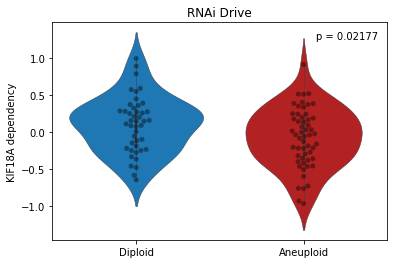

In [16]:
##########################################################################################
######################################### figex 10e ######################################
##########################################################################################

anot = pd.read_csv('aneuploidy_data_NEW_COMPACT.csv',index_col=0)

anot_CCLE = anot.copy()
anot_CCLE.index = anot_CCLE.loc[:,'CCLE_ID']

genes = ['KIF18A (81930)']

gene_effect_rnai_drive_ = gene_effect_rnai_drive.loc[:,genes].dropna()
gene_effect_rnai_achilles_ = gene_effect_rnai_achilles.loc[:,genes].dropna()
gene_effect_crispr_achilles_ = gene_effect_crispr_achilles.loc[:,genes].dropna()


for_doubling = anot_CCLE.loc[set(gene_effect_rnai_drive_.index & anot_CCLE.index),'RNAi_doubling_time'].dropna().index


mu = gene_effect_rnai_drive_.loc[for_doubling,genes].mean()
reg = LinearRegression().fit(np.array(anot_CCLE.loc[for_doubling,'RNAi_doubling_time']).reshape(-1, 1), gene_effect_rnai_drive_.loc[for_doubling])
preds = pd.DataFrame(reg.predict(np.array(anot_CCLE.loc[for_doubling,'RNAi_doubling_time']).reshape(-1,1)),index = for_doubling,columns = gene_effect_rnai_drive_.columns)

preds_ = preds 
corrected_rnai_drive_doubling_time = ((gene_effect_rnai_drive_.loc[for_doubling] - mu) - preds_)+ mu



fig,ax = plt.subplots()


shared = set(anot.loc[:,'CCLE_ID']) & set(corrected_rnai_drive_doubling_time.index)
temp = corrected_rnai_drive_doubling_time.loc[shared]
temp['ploidy'] = anot_CCLE.loc[temp.index,'many_arm_events']

trus = temp[temp.loc[:,'ploidy']==True].index 
temp.loc[trus,'ploidy']= 'Aneuploid'
falsee = temp[temp.loc[:,'ploidy']==False].index 
temp.loc[falsee,'ploidy']=  'Diploid'

my_pal = {"Diploid": "C0", "Aneuploid": "firebrick"}
sns.violinplot(y = 'KIF18A (81930)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=ax,order=['Diploid','Aneuploid'],palette=my_pal)   
sns.swarmplot(y = 'KIF18A (81930)',x='ploidy', data = temp,color='black',alpha=.4,ax=ax,order=['Diploid','Aneuploid'])
ax.set_title('RNAi Drive')
ax.set_ylabel('KIF18A dependency')
ax.set_xlabel('')




tt,p_val = stats.ttest_ind(corrected_rnai_drive_doubling_time.loc[trus,'KIF18A (81930)'],corrected_rnai_drive_doubling_time.loc[falsee,'KIF18A (81930)'])
ax.legend(title='p = '+ str(round(p_val,5)),frameon=False)

No handles with labels found to put in legend.


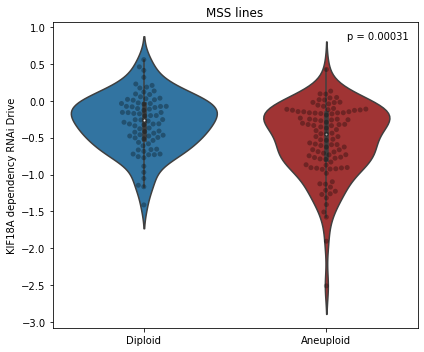

In [22]:
##########################################################################################
######################################### figex 10f ######################################
##########################################################################################

msi = pd.read_csv('Chan_et_al_2019_Supplementary_Table_1.csv',index_col='CCLE_ID')

temp = pd.DataFrame(anot_CCLE.loc[:,'num_arm_events'])
kif = 'KIF18A (81930)'

shared = set(anot.loc[:,'CCLE_ID']) & set(gene_effect_rnai_drive.index)
temp = gene_effect_rnai_drive.loc[shared]
temp['ploidy'] = anot_CCLE.loc[temp.index,'many_arm_events']

gene_effect_rnai_drive['MSI'] = msi.loc[set(temp.index & msi.index),'CCLE_MSI'].replace('indeterminate',float('NaN'))



trus = temp[temp.loc[:,'ploidy']==True].index 
temp.loc[trus,'ploidy']= 'Aneuploid'
falsee = temp[temp.loc[:,'ploidy']==False].index 
temp.loc[falsee,'ploidy']=  'Diploid'

plt.subplots(figsize=(6,5))

ax = sns.violinplot( y=kif, x="ploidy",
                     data=temp ,palette = my_pal,order=['Diploid','Aneuploid'])#palette="muted")

ax = sns.swarmplot( y=kif, x="ploidy",
                     data=temp ,order=['Diploid','Aneuploid'],color='black',alpha=.3)#palette="muted")

plt.xlabel('')

tt,p_val = stats.ttest_ind(temp.loc[trus,kif].dropna(),temp.loc[falsee,kif].dropna())
ax.legend(title='p = '+ str(round(p_val,5)),frameon=False)

plt.ylabel('KIF18A dependency RNAi Drive')
plt.title('MSS lines')
plt.tight_layout()



<ipython-input-24-3222f6212219>:23: FutureWarning: Interpreting call
	'.reindex(a, b)' as 
	'.reindex(index=a, columns=b)'.
Use named arguments to remove any ambiguity. In the future, using positional arguments for 'index' or 'columns' will raise a 'TypeError'.
  summed = damaging_mutation.reindex(all_lines,all_columns).replace(float('nan'),0) + hotspot_mutation.reindex(all_lines,all_columns).replace(float('nan'),0) + other_mutation.reindex(all_lines,all_columns).replace(float('nan'),0)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PTEN_Diploid v.s. PTEN_Aneuploid: t-test independent samples, P_val=2.463e-02 stat=2.270e+00
CTCF_Diploid v.s. CTCF_Aneuploid: t-test independent samples, P_val=5.264e-03 stat=2.830e+00
ARID1A_Diploid v.s. ARID1A_Aneuploid: t-test independent samples, P_val=5.534e-03 stat=2.818e+00
RNF43_Diploid v.s. RNF43_Aneuploid: t-test independent samples, P_val=1.040e-03 stat=3.343e+00


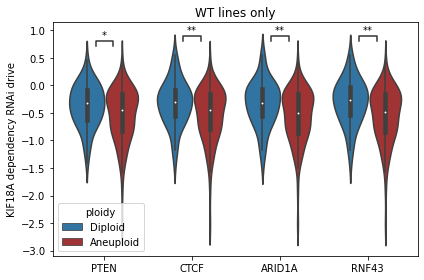

In [24]:
##########################################################################################
######################################### figex 10g ######################################
##########################################################################################

# WT status genes


damaging_mutation = tc.get(name='depmap-mutation-calls-9a1a', version=14, file='damaging_mutation')
depmap_19Q4_mutation_calls = tc.get(name='depmap-mutation-calls-9a1a', version=14, file='depmap_19Q4_mutation_calls')
hotspot_mutation = tc.get(name='depmap-mutation-calls-9a1a', version=14, file='hotspot_mutation')
other_mutation = tc.get(name='depmap-mutation-calls-9a1a', version=14, file='other_mutation')



ARID1A = depmap_19Q4_mutation_calls[depmap_19Q4_mutation_calls.loc[:,'Hugo_Symbol'] == 'ARID1A']
CTCF = depmap_19Q4_mutation_calls[depmap_19Q4_mutation_calls.loc[:,'Hugo_Symbol'] == 'CTCF']
PTEN = depmap_19Q4_mutation_calls[depmap_19Q4_mutation_calls.loc[:,'Hugo_Symbol'] == 'PTEN']
RNF43 = depmap_19Q4_mutation_calls[depmap_19Q4_mutation_calls.loc[:,'Hugo_Symbol'] == 'RNF43']

all_lines = set(damaging_mutation.index) | set(hotspot_mutation.index) | set(other_mutation.index)
all_columns = set(damaging_mutation.columns) | set(hotspot_mutation.columns) | set(other_mutation.columns)

summed = damaging_mutation.reindex(all_lines,all_columns).replace(float('nan'),0) + hotspot_mutation.reindex(all_lines,all_columns).replace(float('nan'),0) + other_mutation.reindex(all_lines,all_columns).replace(float('nan'),0)
summed = summed.replace(float('nan'),0)
summed.columns = summed.columns.str.split(' ').str[0]


ARID1A_wt_ = pd.Series('ARID1A',index=summed[summed.loc[:,'ARID1A'] == 0].index,)
CTCF_wt_ = pd.Series('CTCF',index=summed[summed.loc[:,'CTCF'] == 0].index)
PTEN_wt_ = pd.Series('PTEN',index=summed[summed.loc[:,'PTEN'] == 0].index)
RNF43_wt_ = pd.Series('RNF43',index=summed[summed.loc[:,'RNF43'] == 0].index)


alls_ = pd.concat([ARID1A_wt_,CTCF_wt_])
alls_ = pd.concat([alls_,PTEN_wt_])
alls_ = pd.concat([alls_,RNF43_wt_])

lines =  set(depmap_19Q4_mutation_calls.index)



gene_effect_rnai_achilles_ = gene_effect_rnai_achilles.loc[set(gene_effect_rnai_achilles.index & sample_info.index)].copy()
gene_effect_rnai_drive_ = gene_effect_rnai_drive.loc[set(gene_effect_rnai_drive.index & sample_info.index)].copy()

gene_effect_rnai_achilles_.index = sample_info.loc[set(gene_effect_rnai_achilles.index & sample_info.index),'DepMap_ID']
gene_effect_rnai_drive_.index = sample_info.loc[set(gene_effect_rnai_drive.index & sample_info.index),'DepMap_ID']

alls_ = pd.DataFrame(alls_)
alls_['KIF18A'] = gene_effect_rnai_drive_.loc[set(alls_.index & gene_effect_rnai_drive_.index),kif]
alls_.columns = ['gene','KIF18A']






shared = set(anot.index) & set(alls_.dropna().index)
temp = alls_.dropna().copy()
temp['ploidy'] = anot.loc[set(temp.index & anot.index),'many_arm_events']

trus = temp[temp.loc[:,'ploidy']==True].index 
temp.loc[trus,'ploidy']= 'Aneuploid'
falsee = temp[temp.loc[:,'ploidy']==False].index 
temp.loc[falsee,'ploidy']=  'Diploid'


ax = sns.violinplot(x="gene", y="KIF18A", hue="ploidy",
                     data=temp,palette = my_pal,
                   hue_order=['Diploid','Aneuploid'],order=['PTEN', 'CTCF', 'ARID1A', 'RNF43'])#palette="muted")

plt.xlabel('')
plt.ylabel('KIF18A dependency RNAi drive')

box_pairs=[
    (("ARID1A", "Diploid"), ("ARID1A", "Aneuploid")),
    (("CTCF", "Diploid"), ("CTCF", "Aneuploid")),
    (("PTEN", "Diploid"), ("PTEN", "Aneuploid")),
    (("RNF43", "Diploid"), ("RNF43", "Aneuploid"))
    ]
width = 0.4
add_stat_annotation(ax, data=temp,x="gene", y='KIF18A', hue='ploidy', width=width,
                    box_pairs=box_pairs, test='t-test_ind', loc='inside', verbose=2,order=['PTEN', 'CTCF', 'ARID1A', 'RNF43'],comparisons_correction=None)

plt.title('WT lines only')
plt.tight_layout()



No handles with labels found to put in legend.


RNAi Achilles p-value for KIF18A: 0.023846314476666144


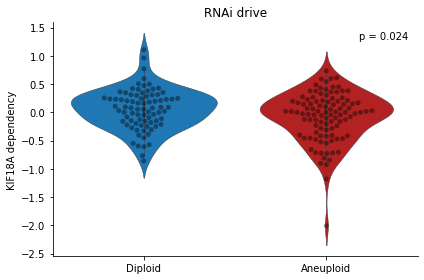

In [26]:
##########################################################################################
######################################### figex 10h ######################################
##########################################################################################

# correct for sublineage_subtype

genes = ['KIF18A (81930)']

gene_effect_rnai_drive_ = gene_effect_rnai_drive.loc[:,genes].dropna()
gene_effect_rnai_achilles_ = gene_effect_rnai_achilles.loc[:,genes].dropna()
gene_effect_crispr_achilles_ = gene_effect_crispr_achilles.loc[:,genes].dropna()


# correct for lineage_subtype
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

one_hot = pd.get_dummies(sample_info.loc[set(gene_effect_rnai_achilles_.index &sample_info.index) ,'lineage_subtype'])
mu = gene_effect_rnai_achilles_.mean()
reg = LinearRegression().fit(one_hot, gene_effect_rnai_achilles_)
preds = pd.DataFrame(reg.predict(one_hot),index = gene_effect_rnai_achilles_.index,columns = gene_effect_rnai_achilles_.columns)

preds_ = preds 
corrected_rnai_achilles = ((gene_effect_rnai_achilles_  - mu)- preds_)+ mu


enc = OneHotEncoder(handle_unknown='ignore')

one_hot = pd.get_dummies(sample_info.loc[set(gene_effect_rnai_drive_.index & sample_info.index),'lineage_subtype'])
mu = gene_effect_rnai_drive_.mean()
reg = LinearRegression().fit(one_hot, gene_effect_rnai_drive_.loc[set(gene_effect_rnai_drive_.index & sample_info.index)])
preds = pd.DataFrame(reg.predict(one_hot),index = gene_effect_rnai_drive_.loc[set(gene_effect_rnai_drive_.index & sample_info.index)].index,columns = gene_effect_rnai_drive_.columns)

preds_ = preds 
corrected_rnai_drive = ((gene_effect_rnai_drive_ - mu) - preds_)+ mu


from scipy import stats


fig,axx = plt.subplots()


shared = set(anot.loc[:,'CCLE_ID']) & set(corrected_rnai_drive.index)
temp = corrected_rnai_drive.loc[shared]
temp['ploidy'] = anot_CCLE.loc[temp.index,'many_arm_events']

trus = temp[temp.loc[:,'ploidy']==True].index 
temp.loc[trus,'ploidy']= 'Aneuploid'
falsee = temp[temp.loc[:,'ploidy']==False].index 
temp.loc[falsee,'ploidy']=  'Diploid'


sns.violinplot(y = 'KIF18A (81930)',x='ploidy', data = temp,saturation=1,linewidth=.5,ax=axx,order=['Diploid','Aneuploid'],palette=my_pal)
sns.swarmplot(y = 'KIF18A (81930)',x='ploidy', data = temp,color='black',alpha=.4,ax=axx,order=['Diploid','Aneuploid'])
axx.set_title('RNAi drive')
axx.set_ylabel('KIF18A dependency')
axx.set_xlabel('')

# plotting.simpleaxis(axx[1])
plt.tight_layout()

axx.spines['right'].set_visible(False)
axx.spines['top'].set_visible(False)

# tt,p_val = stats.ttest_ind(corrected_rnai_drive.loc[trus,'BUB1B (701)'],corrected_rnai_drive.loc[falsee,'BUB1B (701)'])
# print('RNAi Achilles p-value for BUB1B: ' + str(p_val))
# axx[0].legend(title='p = '+ str(round(p_val,4)),frameon=False)
# tt,p_val = stats.ttest_ind(corrected_rnai_drive.loc[trus,'MAD2L1 (4085)'],corrected_rnai_drive.loc[falsee,'MAD2L1 (4085)'])
# print('RNAi Achilles p-value for MAD2L1: ' + str(p_val))
# axx[1].legend(title='p = '+ str(round(p_val,3)),frameon=False)


tt,p_val = stats.ttest_ind(corrected_rnai_drive.loc[trus,'KIF18A (81930)'],corrected_rnai_drive.loc[falsee,'KIF18A (81930)'])
print('RNAi Achilles p-value for KIF18A: ' + str(p_val))
axx.legend(title='p = '+ str(round(p_val,3)),frameon=False)




No handles with labels found to put in legend.


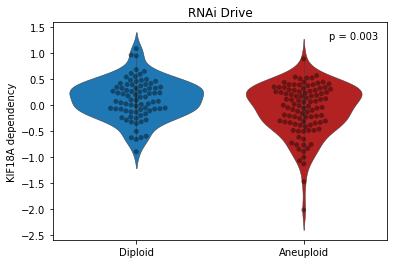

In [27]:
##########################################################################################
######################################### figex 10i ######################################
##########################################################################################

sample_info_depmap = sample_info.copy()
sample_info_depmap.index = sample_info.loc[:,'DepMap_ID']#.loc[gene_effect_rnai_achilles.index,'lineage']
public_19Q4_proteincoding_tpm = tc.get(name='depmap-rnaseq-expression-data-ccd0', version=16, file='public_19Q4_proteincoding_tpm')

public_19Q4_proteincoding_tpm.columns = public_19Q4_proteincoding_tpm.columns.str.split(' ').str[0]


het70 = pd.read_csv('het70genes.csv')
het70_genes = set(het70.drop([0]).values[:,0]) & set(public_19Q4_proteincoding_tpm.columns)


het70_scores = public_19Q4_proteincoding_tpm.loc[:,het70_genes].mean(axis=1)
public_19Q4_proteincoding_tpm_CCLE = public_19Q4_proteincoding_tpm.copy()
public_19Q4_proteincoding_tpm_CCLE.index = sample_info_depmap.loc[public_19Q4_proteincoding_tpm_CCLE.index,'CCLE_Name']

het70_scores_CCLE = public_19Q4_proteincoding_tpm_CCLE.loc[:,het70_genes].mean(axis=1)


sample_info_depmap = sample_info.copy()
sample_info_depmap.index = sample_info.loc[:,'DepMap_ID']#.loc[gene_effect_rnai_drive.index,'lineage']
public_19Q4_proteincoding_tpm = tc.get(name='depmap-rnaseq-expression-data-ccd0', version=16, file='public_19Q4_proteincoding_tpm')

public_19Q4_proteincoding_tpm.columns = public_19Q4_proteincoding_tpm.columns.str.split(' ').str[0]


het70 = pd.read_csv('het70genes.csv')
het70_genes = set(het70.drop([0]).values[:,0]) & set(public_19Q4_proteincoding_tpm.columns)


het70_scores = public_19Q4_proteincoding_tpm.loc[:,het70_genes].mean(axis=1)
public_19Q4_proteincoding_tpm_CCLE = public_19Q4_proteincoding_tpm.copy()
public_19Q4_proteincoding_tpm_CCLE.index = sample_info_depmap.loc[public_19Q4_proteincoding_tpm_CCLE.index,'CCLE_Name']

het70_scores_CCLE = public_19Q4_proteincoding_tpm_CCLE.loc[:,het70_genes].mean(axis=1)



#rnai drive

for_het = anot_CCLE.index & gene_effect_rnai_drive_.index & het70_scores_CCLE.index


mu = gene_effect_rnai_drive_.loc[for_het].mean()
reg = LinearRegression().fit(np.array(het70_scores_CCLE.loc[for_het]).reshape(-1, 1), gene_effect_rnai_drive_.loc[for_het])
preds = pd.DataFrame(reg.predict(np.array(het70_scores_CCLE.loc[for_het]).reshape(-1,1)),index = for_het,columns = gene_effect_rnai_drive_.columns)

preds_ = preds 
corrected_rnai_drive_het_70 = ((gene_effect_rnai_drive_.loc[for_het] - mu) - preds_)+ mu



fig,ax = plt.subplots()


shared = set(anot.loc[:,'CCLE_ID']) & set(corrected_rnai_drive_het_70.index)
temp = corrected_rnai_drive_het_70.loc[shared]
temp['ploidy'] = anot_CCLE.loc[temp.index,'many_arm_events']

trus = temp[temp.loc[:,'ploidy']==True].index 
temp.loc[trus,'ploidy']= 'Aneuploid'
falsee = temp[temp.loc[:,'ploidy']==False].index 
temp.loc[falsee,'ploidy']=  'Diploid'

my_pal = {"Diploid": "C0", "Aneuploid": "firebrick"}
sns.violinplot(y = kif,x='ploidy', data = temp,saturation=1,linewidth=.5,ax=ax,order=['Diploid','Aneuploid'],palette=my_pal)   
sns.swarmplot(y = kif,x='ploidy', data = temp,color='black',alpha=.4,ax=ax,order=['Diploid','Aneuploid'])
ax.set_title('RNAi Drive')
ax.set_ylabel('KIF18A dependency')
ax.set_xlabel('')


tt,p_val = stats.ttest_ind(corrected_rnai_drive_het_70.loc[trus,kif],corrected_rnai_drive_het_70.loc[falsee,kif])
ax.legend(title='p = '+ str(round(p_val,3)),frameon=False)


